## Perform standard imports

In [1]:
! pip install split-folders

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [3]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/12. Convolutional Neural Network (CNN)

/content/drive/MyDrive/12. Convolutional Neural Network (CNN)


## Prepare train and test sets, loaders

In [7]:
splitfolders.ratio("Circle_Cross", output="Train_Test",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 2011 files [00:47, 41.99 files/s] 


# Creating train and test data generators

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
num_classes = 2
img_shape = (116,116,3)
batch_size = 32

## Creating Training and Testing Datasets


In [10]:
training_set = train_datagen.flow_from_directory('Train_Test/train',
                                                 target_size = (116,116),
                                                 class_mode='binary',
                                                 shuffle = True,
                                                 batch_size = batch_size)


Found 1607 images belonging to 2 classes.


In [11]:
test_set = train_datagen.flow_from_directory('Train_Test/val',
                                                 target_size = (116,116),
                                                 class_mode='binary',
                                                 shuffle = False,
                                                 batch_size = batch_size)


Found 403 images belonging to 2 classes.


##  Create CNN

In [12]:
model = Sequential()
model.add(Conv2D(10 ,kernel_size = (5, 5), padding = 'SAME', input_shape = img_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Conv2D(20, (5, 5), padding='SAME')) # "SAME" tries to pad evenly left and right
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))



In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 116, 10)      760       
                                                                 
 activation (Activation)     (None, 116, 116, 10)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 58, 58, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 20)        5020      
                                                                 
 activation_1 (Activation)   (None, 58, 58, 20)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 20)        0         
 g2D)                                                   

# Setting Early Stopping Criterion

In [15]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 5,
                             verbose =1,
                             restore_best_weights = True)


# Training and Testing the model

In [16]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9) ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
hist = model.fit(training_set,
                              epochs = 500,
                              validation_data = test_set,
                              callbacks = earlystop)

Epoch 1/500
51/51 [==============================] - 10s 83ms/step - loss: 0.5822 - accuracy: 0.6814 - val_loss: 0.1975 - val_accuracy: 0.9032
Epoch 2/500
51/51 [==============================] - 5s 95ms/step - loss: 0.4478 - accuracy: 0.8301 - val_loss: 0.1419 - val_accuracy: 0.9479
Epoch 3/500
51/51 [==============================] - 3s 64ms/step - loss: 0.0539 - accuracy: 0.9826 - val_loss: 0.0115 - val_accuracy: 0.9950
Epoch 4/500
51/51 [==============================] - 3s 63ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 0.9975
Epoch 5/500
51/51 [==============================] - 4s 76ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/500
51/51 [==============================] - 3s 67ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/500
51/51 [==============================] - 3s 61ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch

In [18]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

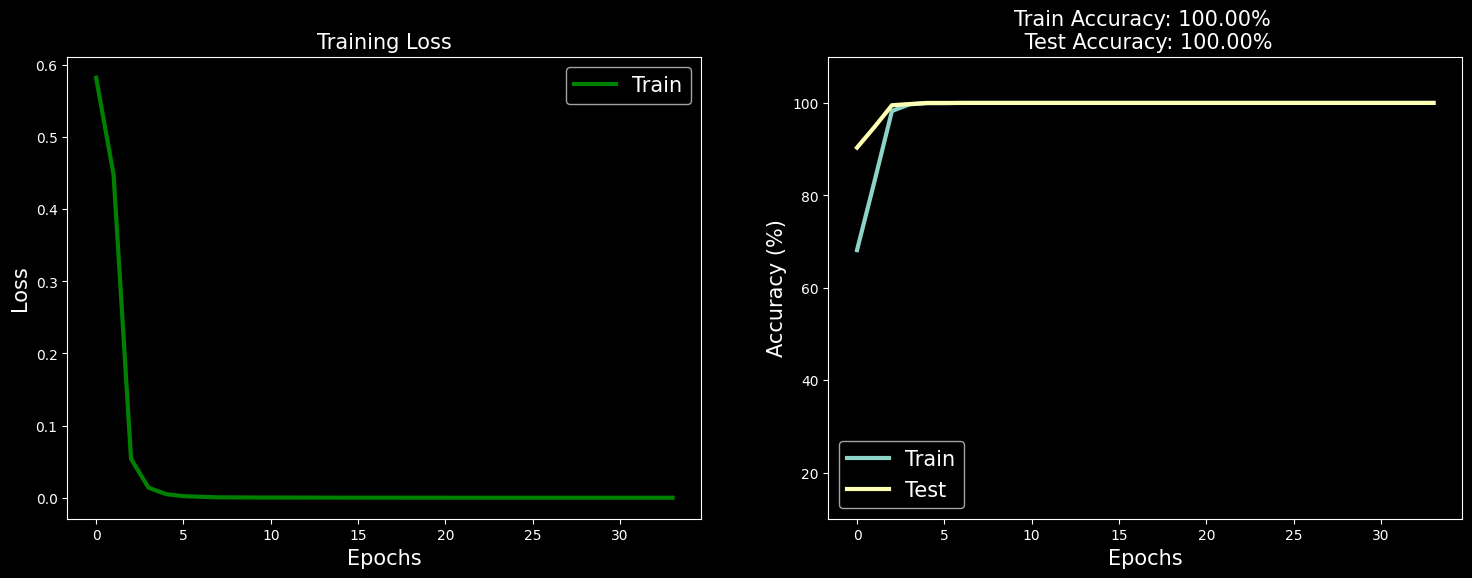

In [19]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()